# Multi-SOI Optimization Demo

This notebook demonstrates how to optimize the Magnetic Reference Layer (MRL) and Capping Layer structure for a **sum of SOIs** (as the paper did). The goal is to find a single structure that provides good sensitivity for a diverse range of magnetic films using the scipy library. 


In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


sys.path.append(os.path.abspath("../"))

from problems.base1 import Base1OptimizationProblem, Materials, MRL, Bounds, SOISpec, CapSpec, SubstrateSpec

##  Setup 



In [2]:
# Substrate
sub = SubstrateSpec(name="Si", rho_n=2.07, sigma=3.0)

# Candidate Caps just testing
caps = {
    "Al2O3": CapSpec(name="Al2O3", nom_thickness=50.0, rho_n=3.5, sigma=3.0),
    "Ti":    CapSpec(name="Ti",    nom_thickness=50.0, rho_n=-1.94, sigma=3.0),
    "MgO":   CapSpec(name="MgO",   nom_thickness=50.0, rho_n=5.38, sigma=3.0),
    "Au":    CapSpec(name="Au",    nom_thickness=50.0, rho_n=4.5, sigma=3.0),
    "SiO2":  CapSpec(name="SiO2",  nom_thickness=50.0, rho_n=3.4, sigma=3.0),
    "TiO2":  CapSpec(name="TiO2",  nom_thickness=50.0, rho_n=2.61, sigma=3.0),
    "TiO2_anatase": CapSpec(name="TiO2_anatase", nom_thickness=50.0, rho_n=3.65, sigma=3.0),
    "TiO2_rutile": CapSpec(name="TiO2_rutile", nom_thickness=50.0, rho_n=4.08, sigma=3.0),
}

# MRL Definition 
def magnetic_sld_func(x_coti): 
    return 1.08 * x_coti

mrl = MRL(
    rho_n_Co=1.21, 
    rho_n_Ti=-1.94, 
    m_sld_from_x=magnetic_sld_func, 
    sigma_sub_mrl=5.0, 
    sigma_mrl_cap=5.0
)

materials = Materials(substrate=sub, caps=caps, mrl=mrl)

##  Define List of SOIs


In [3]:
soi_list = [
    SOISpec(name="Film_LowDensity",  rho_n=1.0, thickness=400.0, sigma=2.0),
    SOISpec(name="Film_HighDensity", rho_n=4.0, thickness=600.0, sigma=5.0),
    SOISpec(name="Film_Thick",       rho_n=2.0, thickness=150.0, sigma=3.0),
    SOISpec(name="Film_Thin",      rho_n=3.0, thickness=200.0,  sigma=2.0),
    SOISpec(name="build_like", rho_n=2.0, thickness=500.0, sigma=15.0)
]

print(f"Optimizing for {len(soi_list)} SOIs:")
for s in soi_list:
    print(f" - {s.name}: d={s.thickness}A, rho={s.rho_n}")

Optimizing for 5 SOIs:
 - Film_LowDensity: d=400.0A, rho=1.0
 - Film_HighDensity: d=600.0A, rho=4.0
 - Film_Thick: d=150.0A, rho=2.0
 - Film_Thin: d=200.0A, rho=3.0
 - build_like: d=500.0A, rho=2.0


##  Init Optimization Problem


In [4]:
q_grid = np.linspace(0.005, 0.3, 300)

# Bounds for variables
bounds_x = Bounds(0, 1)
bounds_d = Bounds(10, 1200) # MRL Thickness
bounds_cap = Bounds(10, 200) # Cap Thickness

problem = Base1OptimizationProblem(
    materials=materials, 
    soi_list=soi_list, 
    q_grid=q_grid, 
    bounds_x=bounds_x, 
    bounds_d=bounds_d, 
    bounds_cap=bounds_cap
)

## Run Optimization using Scipy



In [5]:
# Fixed Parameters
FIXED_X_COTI = 0.73

best_result = {
    "score": -np.inf,
    "cap": None,
    "d_mrl": 0,
    "d_cap": 0
}

results_log = []

print("Starting Optimization...")

for cap_name in caps.keys():
    print(f"\nOptimizing for Cap: {cap_name}...")
    
    
    # x vector = [d_mrl, d_cap] since thickness is capped 
    def objective_func(x):
        d_mrl_val, d_cap_val = x
        
        # The problem class sums TSF over all SOIs automatically
        score = problem.evaluate_objective(
            x_coti=FIXED_X_COTI,
            d_mrl=d_mrl_val,
            d_cap=d_cap_val,
            cap=cap_name
        )
        return -score # minimize neg

    # Initial Guess & Bounds
    x0 = [100.0, 50.0]
    bnds = [
        (bounds_d.lo, bounds_d.hi), 
        (bounds_cap.lo, bounds_cap.hi)
    ]

    # Run Scipy Minimize
    res = minimize(
        objective_func,
        x0,
        bounds=bnds,
        method='L-BFGS-B',
        tol=1e-4
    )
    
    current_score = -res.fun
    d_mrl_opt, d_cap_opt = res.x

    print(f"  > Best Score: {current_score:.4f}")
    print(f" > Params: d_mrl={d_mrl_opt:.1f}, d_cap={d_cap_opt:.1f}")
    
    results_log.append((cap_name, current_score, d_mrl_opt, d_cap_opt))
    
    if current_score > best_result["score"]:
        best_result["score"] = current_score
        best_result["cap"] = cap_name
        best_result["d_mrl"] = d_mrl_opt
        best_result["d_cap"] = d_cap_opt

print("\n" + "="*30)
print("GLOBAL OPTIMUM FOUND")
print(f"Cap: {best_result['cap']}")
print(f"MRL Thickness: {best_result['d_mrl']:.2f} A")
print(f"Cap Thickness: {best_result['d_cap']:.2f} A")
print(f"Total TSF Score: {best_result['score']:.4f}")
print("="*30)

Starting Optimization...

Optimizing for Cap: Al2O3...
  > Best Score: 0.0178
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: Ti...
  > Best Score: 0.0136
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: MgO...
  > Best Score: 0.0200
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: Au...
  > Best Score: 0.0203
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: SiO2...
  > Best Score: 0.0174
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: TiO2...
  > Best Score: 0.0156
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: TiO2_anatase...
  > Best Score: 0.0183
 > Params: d_mrl=100.0, d_cap=50.0

Optimizing for Cap: TiO2_rutile...
  > Best Score: 0.0196
 > Params: d_mrl=100.0, d_cap=50.0

GLOBAL OPTIMUM FOUND
Cap: Au
MRL Thickness: 100.00 A
Cap Thickness: 50.00 A
Total TSF Score: 0.0203


# Without Predefined Ratio

In [6]:
best_result = {
    "score": -np.inf,
    "cap": None,
    "x_coti": None,
    "d_mrl": None,
    "d_cap": None,
}

results_log = []

print("Starting Optimization (including x_coti)...")

# --- choose bounds for x_coti  ---
bounds_x_coti = (0.0, 1.0)

for cap_name in caps.keys():
    print(f"\nOptimizing for Cap: {cap_name}...")

    # x vector = [x_coti, d_mrl, d_cap]
    def objective_func(x):
        x_coti_val, d_mrl_val, d_cap_val = x

        score = problem.evaluate_objective(
            x_coti=float(x_coti_val),
            d_mrl=float(d_mrl_val),
            d_cap=float(d_cap_val),
            cap=cap_name
        )
        return -score  # minimize negative => maximize score

    # Initial Guess (pick something inside bounds)
    x0 = [0.73, 100.0, 50.0]

    # Bounds: [(x_coti_lo, x_coti_hi), (d_mrl_lo, d_mrl_hi), (d_cap_lo, d_cap_hi)]
    bnds = [
        bounds_x_coti,
        (bounds_d.lo, bounds_d.hi),
        (bounds_cap.lo, bounds_cap.hi),
    ]

    res = minimize(
        objective_func,
        x0,
        bounds=bnds,
        method="L-BFGS-B",
        tol=1e-4,
    )

    current_score = -float(res.fun)
    x_coti_opt, d_mrl_opt, d_cap_opt = map(float, res.x)

    print(f"  > Best Score: {current_score:.4f}")
    print(f"  > Params: x_coti={x_coti_opt:.4f}, d_mrl={d_mrl_opt:.1f}, d_cap={d_cap_opt:.1f}")

    results_log.append((cap_name, current_score, x_coti_opt, d_mrl_opt, d_cap_opt))

    if current_score > best_result["score"]:
        best_result.update({
            "score": current_score,
            "cap": cap_name,
            "x_coti": x_coti_opt,
            "d_mrl": d_mrl_opt,
            "d_cap": d_cap_opt,
        })

print("\n" + "=" * 30)
print("GLOBAL OPTIMUM FOUND")
print(f"Cap: {best_result['cap']}")
print(f"x_coti: {best_result['x_coti']:.6f}")
print(f"MRL Thickness: {best_result['d_mrl']:.2f} A")
print(f"Cap Thickness: {best_result['d_cap']:.2f} A")
print(f"Total TSF Score: {best_result['score']:.4f}")
print("=" * 30)

Starting Optimization (including x_coti)...

Optimizing for Cap: Al2O3...
  > Best Score: 0.0662
  > Params: x_coti=1.0000, d_mrl=70.9, d_cap=10.0

Optimizing for Cap: Ti...
  > Best Score: 0.0152
  > Params: x_coti=0.5153, d_mrl=100.0, d_cap=50.0

Optimizing for Cap: MgO...
  > Best Score: 0.0666
  > Params: x_coti=1.0000, d_mrl=69.3, d_cap=10.0

Optimizing for Cap: Au...
  > Best Score: 0.0614
  > Params: x_coti=1.0000, d_mrl=95.9, d_cap=10.0

Optimizing for Cap: SiO2...
  > Best Score: 0.0661
  > Params: x_coti=1.0000, d_mrl=71.3, d_cap=10.0

Optimizing for Cap: TiO2...
  > Best Score: 0.0638
  > Params: x_coti=1.0000, d_mrl=60.0, d_cap=33.2

Optimizing for Cap: TiO2_anatase...
  > Best Score: 0.0665
  > Params: x_coti=1.0000, d_mrl=67.6, d_cap=10.0

Optimizing for Cap: TiO2_rutile...
  > Best Score: 0.0667
  > Params: x_coti=1.0000, d_mrl=67.4, d_cap=10.0

GLOBAL OPTIMUM FOUND
Cap: TiO2_rutile
x_coti: 1.000000
MRL Thickness: 67.38 A
Cap Thickness: 10.00 A
Total TSF Score: 0.0667


# Better version of Opt 

In [7]:
import time
import numpy as np
from scipy.optimize import differential_evolution, minimize

TIME_BUDGET_S = 2 * 60
SEED = 0

# ---- FIXA Co–Ti ratio här ----
X_COTI_FIXED = 0.73   # Co-fraktion (Ti blir 1 - X_COTI_FIXED)

for cap_name in caps.keys():
    print(f"\nOptimizing for Cap: {cap_name} (x_coti fixed = {X_COTI_FIXED:.4f})...")

    # x vector = [d_mrl, d_cap]
    def objective_func(x):
        d_mrl_val, d_cap_val = x
        score = problem.evaluate_objective(
            x_coti=float(X_COTI_FIXED),     # <-- FIX
            d_mrl=float(d_mrl_val),
            d_cap=float(d_cap_val),
            cap=cap_name
        )
        return -float(score)

    # Bounds: [(d_mrl_lo, d_mrl_hi), (d_cap_lo, d_cap_hi)]
    bnds = [
        (bounds_d.lo, bounds_d.hi),
        (bounds_cap.lo, bounds_cap.hi),
    ]

    start = time.monotonic()
    def stop_if_time_up(xk, convergence):
        return (time.monotonic() - start) > TIME_BUDGET_S

    # Global exploration (2D nu)
    de_res = differential_evolution(
        objective_func,
        bounds=bnds,
        strategy="best1bin",
        maxiter=10_000,
        popsize=25,
        tol=0.0,
        mutation=(0.5, 1.0),
        recombination=0.7,
        seed=SEED,
        polish=False,
        updating="deferred",
        workers=1,
        callback=stop_if_time_up,
        disp=False,
    )

    # Local polish
    polish = minimize(
        objective_func,
        x0=de_res.x,
        method="L-BFGS-B",
        bounds=bnds,
        options={
            "maxiter": 5000,
            "ftol": 1e-12,
            "gtol": 1e-10,
        },
    )

    best_x = polish.x
    best_score = -float(polish.fun)

    d_mrl_opt, d_cap_opt = map(float, best_x)
    print(f"  > Best Score: {best_score:.6f}")
    print(f"  > Params: x_coti={X_COTI_FIXED:.6f}, d_mrl={d_mrl_opt:.3f}, d_cap={d_cap_opt:.3f}")



Optimizing for Cap: Al2O3 (x_coti fixed = 0.7300)...
  > Best Score: 0.040295
  > Params: x_coti=0.730000, d_mrl=41.231, d_cap=24.379

Optimizing for Cap: Ti (x_coti fixed = 0.7300)...
  > Best Score: 0.029121
  > Params: x_coti=0.730000, d_mrl=1191.913, d_cap=17.857

Optimizing for Cap: MgO (x_coti fixed = 0.7300)...
  > Best Score: 0.041757
  > Params: x_coti=0.730000, d_mrl=45.215, d_cap=15.062

Optimizing for Cap: Au (x_coti fixed = 0.7300)...
  > Best Score: 0.041270
  > Params: x_coti=0.730000, d_mrl=43.750, d_cap=18.173

Optimizing for Cap: SiO2 (x_coti fixed = 0.7300)...
  > Best Score: 0.040118
  > Params: x_coti=0.730000, d_mrl=40.768, d_cap=25.119

Optimizing for Cap: TiO2 (x_coti fixed = 0.7300)...
  > Best Score: 0.037900
  > Params: x_coti=0.730000, d_mrl=38.553, d_cap=35.221

Optimizing for Cap: TiO2_anatase (x_coti fixed = 0.7300)...
  > Best Score: 0.040506
  > Params: x_coti=0.730000, d_mrl=41.809, d_cap=23.226

Optimizing for Cap: TiO2_rutile (x_coti fixed = 0.7300)

##  Visualize Results


<>:15: SyntaxWarning: invalid escape sequence '\A'
<>:15: SyntaxWarning: invalid escape sequence '\A'
/var/folders/d7/lqdbw8kx7hdfnmgw2bl0hhwc0000gn/T/ipykernel_3103/3587298944.py:15: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Q (${\AA}^{-1}$)')


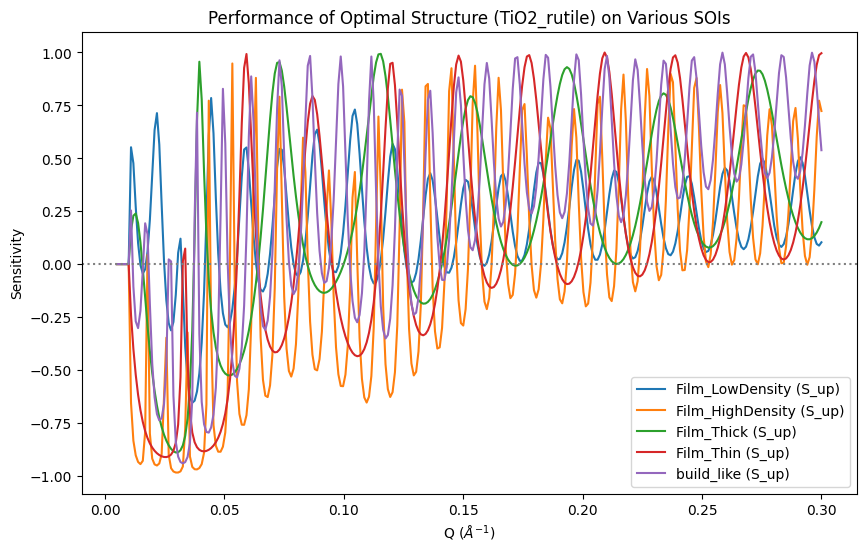

In [8]:
plt.figure(figsize=(10, 6))

# Plot Sensitivity for each SOI using the optimal parameters
for s in soi_list:
    res = problem.analyze_single_soi(
        soi=s,
        x_coti=FIXED_X_COTI,
        d_mrl=best_result["d_mrl"],
        d_cap=best_result["d_cap"],
        cap=best_result["cap"]
    )
    plt.plot(res['Q'], res['S_up'], label=f"{s.name} (S_up)")

plt.axhline(0, color='gray', linestyle=':')
plt.xlabel('Q (${\AA}^{-1}$)')
plt.ylabel('Sensitivity')
plt.title(f'Performance of Optimal Structure ({best_result["cap"]}) on Various SOIs')
plt.legend()
plt.show()

## Build-style plots for SciPy solution
Re-use the build.ipynb plotting layout to visualize the SciPy-optimized stack (reflectivity + sensitivities) and sweep TSF over a small MRL interval.


In [9]:
from physics.fom import tsf
from physics.reflectometry import reflectivity as refl

def plot_reflectivity_panels(problem: Base1OptimizationProblem,
                             soi: SOISpec,
                             x_coti: float,
                             d_mrl: float,
                             d_cap: float,
                             cap: str,
                             bkg: float = 1e-3,
                             title_suffix: str = ""):
    """Match the 3-panel build.ipynb reflectivity view."""
    Q = problem.Q
    q_lo = float(Q.min())
    q_hi = float(min(0.12, Q.max()))

    layers_np = problem.layers_no_mrl(soi)
    R_np = problem._reflect(Q, layers_np, bkg=bkg)

    layers_mrl_up, layers_mrl_dn = problem._layers(
        x_coti=x_coti, d_mrl=d_mrl, d_cap=d_cap, cap=cap, soi=None
    )
    R_mrl_up = problem._reflect(Q, layers_mrl_up, bkg=bkg)
    R_mrl_dn = problem._reflect(Q, layers_mrl_dn, bkg=bkg)

    res = problem.analyze_single_soi(
        soi=soi, x_coti=x_coti, d_mrl=d_mrl, d_cap=d_cap, cap=cap, bkg=bkg
    )

    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

    ax = axes[0]
    ax.semilogy(Q, R_np, label="Non-polarized")
    ax.set_xlabel(r"Q ($\AA^{-1}$)")
    ax.set_ylabel("Intensity (a.u.)")
    ax.set_title("(a) SOI + substrate" + title_suffix)
    ax.set_xlim(q_lo, q_hi)

    ax = axes[1]
    ax.semilogy(Q, R_mrl_up, label="Spin-up")
    ax.semilogy(Q, R_mrl_dn, label="Spin-down")
    ax.set_xlabel(r"Q ($\AA^{-1}$)")
    ax.set_ylabel("Intensity (a.u.)")
    ax.set_title("(b) MRL on substrate" + title_suffix)
    ax.legend()
    ax.set_xlim(q_lo, q_hi)

    ax = axes[2]
    ax.semilogy(Q, res["Rfull_up"], label="Spin-up")
    ax.semilogy(Q, res["Rfull_dn"], label="Spin-down")
    ax.set_xlabel(r"Q ($\AA^{-1}$)")
    ax.set_ylabel("Intensity (a.u.)")
    ax.set_title("(c) SOI on MRL" + title_suffix)
    ax.legend()
    ax.set_xlim(q_lo, q_hi)

    fig.tight_layout()
    return fig, axes


def plot_sensitivity_grid(problem: Base1OptimizationProblem,
                          x_coti: float,
                          d_mrl: float,
                          d_cap: float,
                          cap: str,
                          soi_list: list[SOISpec],
                          title_prefix: str = "",
                          bkg: float = 0.0):
    """Row of sensitivities with TSF in the title (matches build.ipynb)."""
    n = len(soi_list)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 3), sharex=True, sharey=True)
    axes = [axes] if n == 1 else list(axes)

    triplets = []
    for ax, soi in zip(axes, soi_list):
        res = problem.analyze_single_soi(
            soi=soi,
            x_coti=x_coti,
            d_mrl=d_mrl,
            d_cap=d_cap,
            cap=cap,
            bkg=bkg,
        )
        Q = res["Q"]
        S_up = res["S_up"]
        S_dn = res["S_dn"]

        ax.plot(Q, S_up, label="Spin-up")
        ax.plot(Q, S_dn, label="Spin-down")
        ax.axhline(0.0, color="k", linewidth=0.5)
        ax.set_xlabel(r"Q ($\AA^{-1}$)")
        ax.set_title(
            f"{title_prefix} {soi.name}\n"
            f"SFM↑={res['SFM_up']:.3f}, SFM↓={res['SFM_dn']:.3f}, MCF={res['MCF']:.3f}"
        )
        triplets.append((res["SFM_up"], res["SFM_dn"], res["MCF"]))

    axes[0].set_ylabel("Sensitivity")
    axes[0].legend(loc="upper right")

    row_tsf = tsf(triplets)
    fig.suptitle(
        f"TSF = {row_tsf:.3f} | cap={cap}, x={x_coti:.3f}, d_mrl={d_mrl:.1f}A, d_cap={d_cap:.1f}A",
        y=1.05,
    )
    fig.tight_layout()
    return fig, axes


def tsf_sweep(problem: Base1OptimizationProblem,
              x_values: np.ndarray,
              d_mrl_values: np.ndarray,
              d_cap: float,
              cap: str):
    """Evaluate TSF over a grid of x_coti and d_mrl values (fixed cap/d_cap)."""
    grid = np.zeros((len(x_values), len(d_mrl_values)))
    rows = []
    for i, x_val in enumerate(x_values):
        for j, d_val in enumerate(d_mrl_values):
            tsf_val = problem.evaluate_objective(
                x_coti=float(x_val), d_mrl=float(d_val), d_cap=float(d_cap), cap=cap
            )
            grid[i, j] = tsf_val
            rows.append({
                "x_coti": float(x_val),
                "d_mrl": float(d_val),
                "d_cap": float(d_cap),
                "cap": cap,
                "tsf": float(tsf_val),
            })
    return grid, rows

In [10]:
def _fallback(val, default):
    return default if val in (None, 0) else float(val)

plot_params = {
    "cap": best_result.get("cap", list(caps.keys())[0]),
    "x_coti": FIXED_X_COTI,
    "d_mrl": _fallback(best_result.get("d_mrl", None), 100.0),
    "d_cap": _fallback(best_result.get("d_cap", None), 50.0),
}

target_soi = soi_list[0]  # pick any SOI to plot; adjust as needed
plot_params

{'cap': 'TiO2_rutile',
 'x_coti': 0.73,
 'd_mrl': 67.38453776349043,
 'd_cap': 10.0}

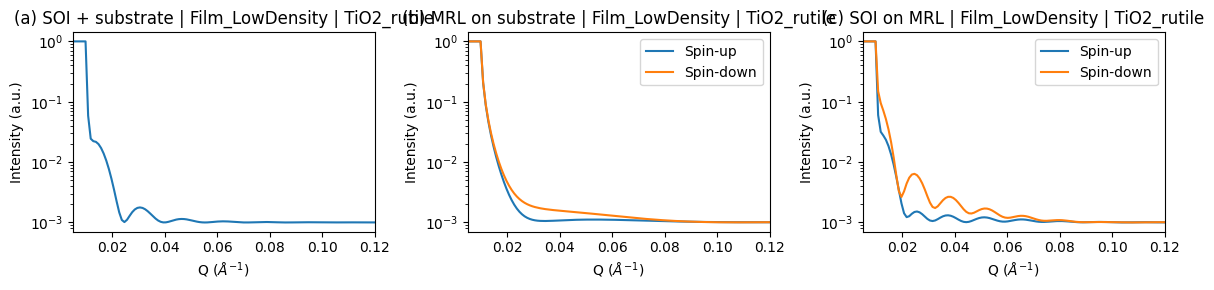

In [11]:
fig, axes = plot_reflectivity_panels(
    problem=problem,
    soi=target_soi,
    x_coti=plot_params["x_coti"],
    d_mrl=plot_params["d_mrl"],
    d_cap=plot_params["d_cap"],
    cap=plot_params["cap"],
    bkg=1e-3,
    title_suffix=f" | {target_soi.name} | {plot_params['cap']}"
)
plt.show()

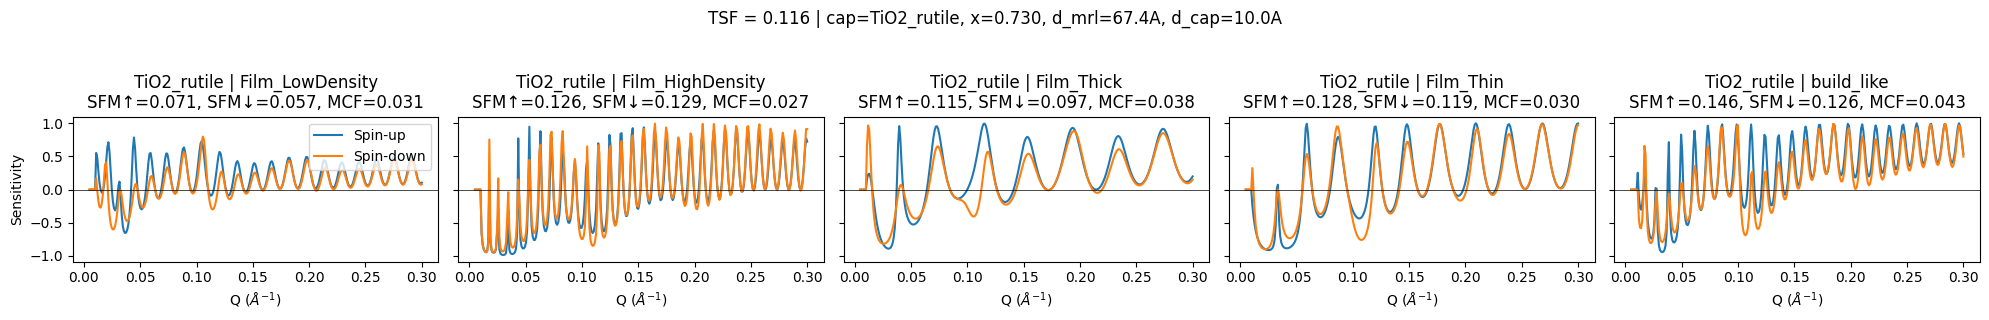

In [12]:
plot_sensitivity_grid(
    problem=problem,
    x_coti=plot_params["x_coti"],
    d_mrl=plot_params["d_mrl"],
    d_cap=plot_params["d_cap"],
    cap=plot_params["cap"],
    soi_list=soi_list,
    title_prefix=f"{plot_params['cap']} |",
    bkg=0.0,
)
plt.show()

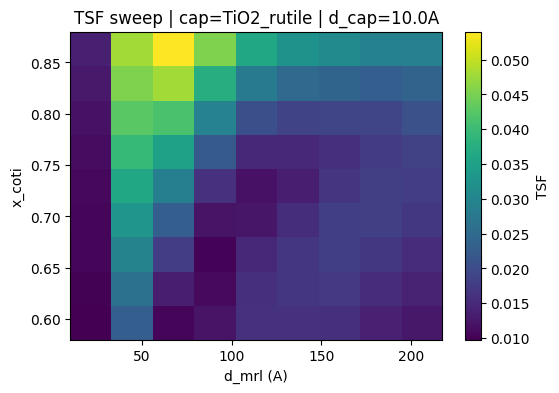

Top TSF points in sweep:
x=0.880, d_mrl=61.8A, d_cap=10.0A, cap=TiO2_rutile, TSF=0.054
x=0.880, d_mrl=35.9A, d_cap=10.0A, cap=TiO2_rutile, TSF=0.048
x=0.843, d_mrl=61.8A, d_cap=10.0A, cap=TiO2_rutile, TSF=0.048
x=0.843, d_mrl=35.9A, d_cap=10.0A, cap=TiO2_rutile, TSF=0.045
x=0.880, d_mrl=87.8A, d_cap=10.0A, cap=TiO2_rutile, TSF=0.045


In [13]:
x_vals = np.linspace(
    max(bounds_x.lo, plot_params["x_coti"] - 0.15),
    min(bounds_x.hi, plot_params["x_coti"] + 0.15),
    9,
)
d_vals = np.linspace(
    max(bounds_d.lo, plot_params["d_mrl"] - 150.0),
    min(bounds_d.hi, plot_params["d_mrl"] + 150.0),
    9,
)

tsf_grid, tsf_rows = tsf_sweep(
    problem=problem,
    x_values=x_vals,
    d_mrl_values=d_vals,
    d_cap=plot_params["d_cap"],
    cap=plot_params["cap"],
)

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(
    tsf_grid,
    origin="lower",
    aspect="auto",
    extent=[d_vals.min(), d_vals.max(), x_vals.min(), x_vals.max()],
)
ax.set_xlabel("d_mrl (A)")
ax.set_ylabel("x_coti")
ax.set_title(f"TSF sweep | cap={plot_params['cap']} | d_cap={plot_params['d_cap']:.1f}A")
fig.colorbar(im, ax=ax, label="TSF")
plt.show()

top = sorted(tsf_rows, key=lambda r: r["tsf"], reverse=True)[:5]
print("Top TSF points in sweep:")
for row in top:
    print(
        f"x={row['x_coti']:.3f}, d_mrl={row['d_mrl']:.1f}A, "
        f"d_cap={row['d_cap']:.1f}A, cap={row['cap']}, TSF={row['tsf']:.3f}"
    )

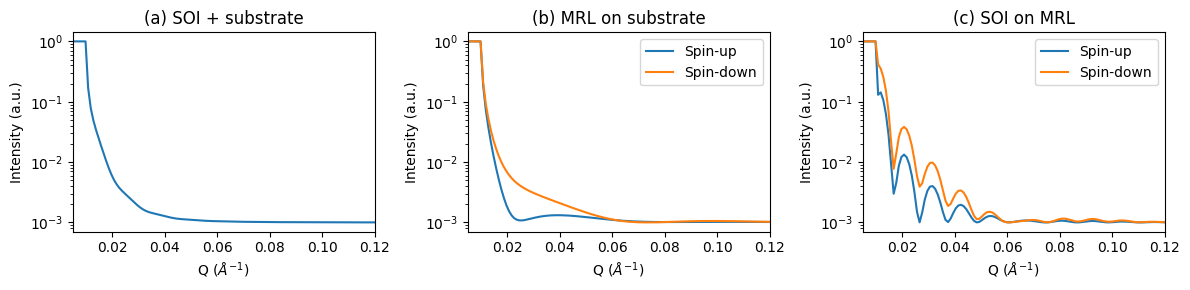

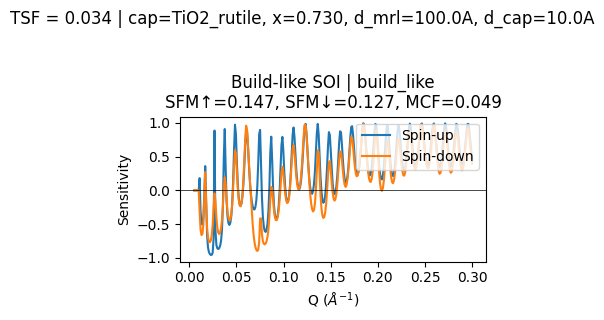

In [14]:
# temporary SOI for build-style comparison
soi_build = SOISpec(name="build_like", rho_n=2.0, thickness=500.0, sigma=15.0)

# plot final stack with build-like SOI and d_mrl bumped to 100 Å
fig, ax = plot_reflectivity_panels(
    problem=problem,
    soi=soi_build,
    x_coti=0.73,
    d_mrl=100.0,
    d_cap=plot_params["d_cap"],   # keep your optimized cap thickness
    cap=plot_params["cap"],
    bkg=1e-3,
)

# sensitivity for the same build-like SOI (fixed x, zero bkg, low-Q)
fig, axes = plot_sensitivity_grid(
    problem=problem,
    x_coti=0.73,
    d_mrl=100.0,
    d_cap=plot_params["d_cap"],
    cap=plot_params["cap"],
    soi_list=[soi_build],
    title_prefix="Build-like SOI |",
    bkg=0.0,
)

plt.show()

